# Evaluating metrics

In [18]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import unicodedata
import Levenshtein

In [19]:
watermarked_path = "../Dataset/Watermarked Audio"
unwatermarked_path = "../Dataset/Unwatermarked Audio"
transcription_path = '../Dataset/Transcriptions/transcriptions_complete.csv'
results_path = '../Dataset/Results'

In [20]:
# Helper to extract the ID from the filename
def extract_id(filename):
    match = re.search(r'common_voice_en_(\d+)', filename)
    return match.group(1) if match else None

# Transcriptios of the original file
transcriptions_w = pd.read_csv('../Dataset/Transcriptions/transcriptions_complete.csv')
# Create ID
transcriptions_w["id"] = transcriptions_w["clip"].apply(extract_id)
transcriptions_w["id"] = transcriptions_w["id"].astype(int).astype(str)

In [21]:
# Import results
watermark_prob = pd.read_csv(os.path.join(results_path, "all_results_watermark_prob.csv"))
# Create log probabilities
watermark_prob["log1p_prob_w"] = np.log1p(watermark_prob["prob_w"])

transcriptions_un = pd.read_csv(os.path.join(results_path, "all_results_transcription.csv"))
transcriptions_un["id"] = transcriptions_un["id"].astype(int).astype(str)

In [22]:
# Probability of Watermarking
watermark_prob["prob_w"].describe().apply(lambda x: f"{x:0.2%}")

count    1412400.00%
mean           0.25%
std            0.82%
min            0.00%
25%            0.00%
50%            0.00%
75%            0.17%
max           28.43%
Name: prob_w, dtype: object

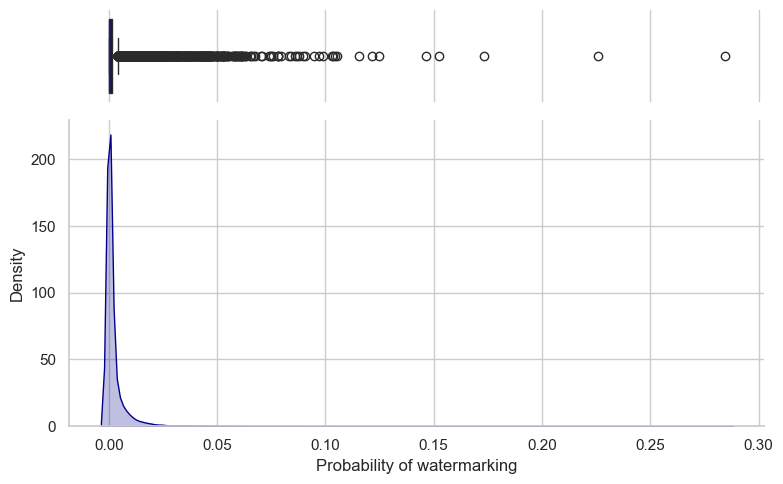

In [23]:
# Set general style
sns.set(style="whitegrid")
fig, (ax_box, ax_kde) = plt.subplots(
    nrows=2, 
    sharex=True, 
    figsize=(8, 5), 
    gridspec_kw={"height_ratios": [0.3, 1]}
)

# Remove space between plots
plt.subplots_adjust(hspace=0)

# Boxplot on top
sns.boxplot(
    data=watermark_prob, 
    x="prob_w", 
    ax=ax_box, 
    color="darkblue", 
    orient="h"
)
ax_box.set(xlabel="")
ax_box.set(yticks=[])
ax_box.spines["left"].set_visible(False)
ax_box.spines["right"].set_visible(False)
ax_box.spines["top"].set_visible(False)
ax_box.spines["bottom"].set_visible(False)

# KDE plot below
sns.kdeplot(
    data=watermark_prob, 
    x="prob_w", 
    fill=True, 
    color="darkblue", 
    ax=ax_kde
)
ax_kde.set_xlabel("Probability of watermarking")

sns.despine(ax=ax_kde)
sns.despine(ax=ax_box, left=True, bottom=True)

plt.tight_layout()
plt.savefig("../Paper/Figures/watermarking_plot.png", bbox_inches='tight', dpi=300, transparent=True)

Text(0.5, 0, '$\\log(1 + \\mathrm{probability\\ of\\ watermarking})$')

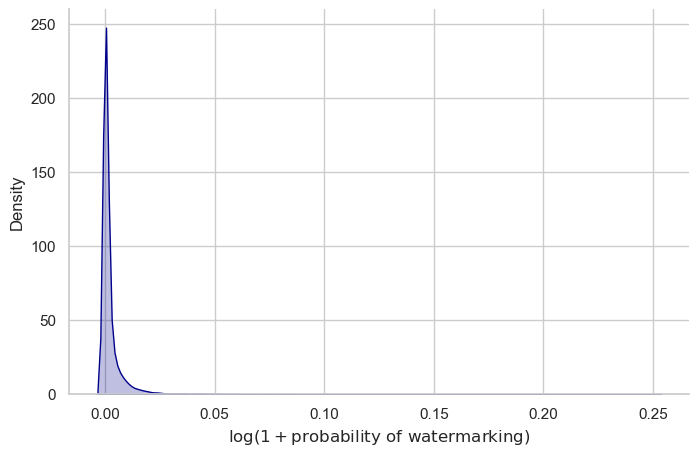

In [24]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.despine()
sns.kdeplot(data = watermark_prob, x = "log1p_prob_w", fill = True,  color = "darkblue")
plt.xlabel(r"$\log(1 + \mathrm{probability\ of\ watermarking})$")

In [25]:
transcriptions = transcriptions_w.merge(transcriptions_un, how = "inner", on = "id").reset_index(drop = True)
transcriptions = transcriptions.drop(columns = "prob_w")
transcriptions.shape[0] == watermark_prob.shape[0]

transcriptions = transcriptions.rename(columns ={
    "transcription": "transcriptions_w",
    "unwatermarked_transcription": "transcriptions_un"
})

In [26]:
def clean_text(x):
    # Lowercase
    x = x.lower()
    
    # Remove accents
    x = unicodedata.normalize('NFD', x)
    x = x.encode('ascii', 'ignore').decode('utf-8')
    
    # Remove special characters (keep only letters and numbers)
    x = re.sub(r'[^a-z0-9\s]', '', x)
    
    # Replace multiple whitespace with a single space
    x = re.sub(r'\s+', ' ', x)
    
    # Trim leading/trailing spaces
    x = x.strip()
    
    return x

clean_text("Hola  papá MOCOSO 203   !")

'hola papa mocoso 203'

In [27]:
transcriptions[["transcriptions_w", "transcriptions_un"]] = transcriptions[["transcriptions_w", "transcriptions_un"]].map(clean_text)

In [28]:
transcriptions["levenshtein_distance"] = transcriptions.apply(lambda row: Levenshtein.distance(row["transcriptions_w"], row["transcriptions_un"]), axis=1)
transcriptions["levenshtein_ratio"] = transcriptions.apply(lambda row: Levenshtein.ratio(row["transcriptions_w"], row["transcriptions_un"]), axis=1)

In [30]:
transcriptions["levenshtein_ratio"].describe().apply(lambda x: f"{x:0.2%}")

count    1412400.00%
mean          75.23%
std           26.17%
min            0.00%
25%           61.44%
50%           83.91%
75%           96.67%
max          100.00%
Name: levenshtein_ratio, dtype: object

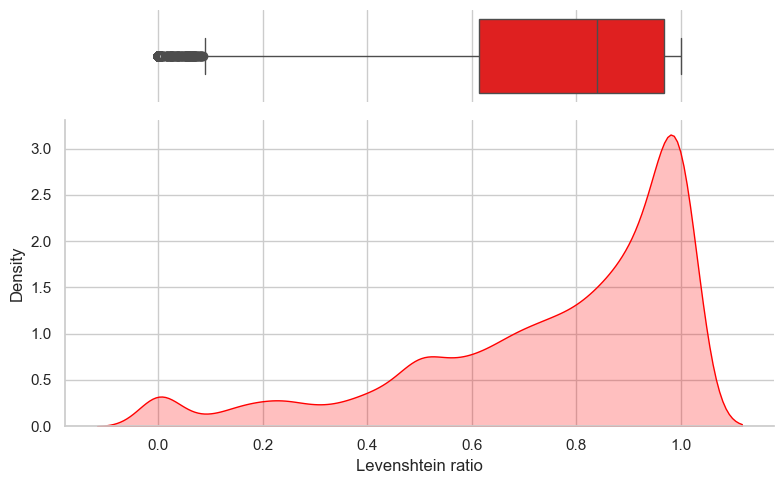

In [33]:
# Set general style
sns.set(style="whitegrid")
fig, (ax_box, ax_kde) = plt.subplots(
    nrows=2, 
    sharex=True, 
    figsize=(8, 5), 
    gridspec_kw={"height_ratios": [0.3, 1]}
)

# Remove space between plots
plt.subplots_adjust(hspace=0)

# Boxplot on top
sns.boxplot(
    data=transcriptions, 
    x="levenshtein_ratio", 
    ax=ax_box, 
    color="red", 
    orient="h"
)
ax_box.set(xlabel="")
ax_box.set(yticks=[])
ax_box.spines["left"].set_visible(False)
ax_box.spines["right"].set_visible(False)
ax_box.spines["top"].set_visible(False)
ax_box.spines["bottom"].set_visible(False)

# KDE plot below
sns.kdeplot(
    data=transcriptions, 
    x="levenshtein_ratio", 
    fill=True, 
    color="red", 
    ax=ax_kde
)
ax_kde.set_xlabel("Levenshtein ratio")

sns.despine(ax=ax_kde)
sns.despine(ax=ax_box, left=True, bottom=True)

plt.tight_layout()
plt.savefig("../Paper/Figures/levenshtein_ratio_plot.png", bbox_inches='tight', dpi=300, transparent=True)

In [31]:
transcriptions.columns

Index(['clip', 'transcriptions_w', 'confidence', 'id', 'transcriptions_un',
       'unwatermarked_confidence', 'levenshtein_distance',
       'levenshtein_ratio'],
      dtype='object')

In [35]:
transcriptions["confidence"].describe()

count    14124.000000
mean         0.999542
std          0.000314
min          0.998859
25%          0.999299
50%          0.999600
75%          0.999819
max          0.999998
Name: confidence, dtype: float64

In [37]:
transcriptions["unwatermarked_confidence"].describe()

count    14124.000000
mean         0.986606
std          0.035035
min          0.424701
25%          0.992247
50%          0.996367
75%          0.998230
max          0.999991
Name: unwatermarked_confidence, dtype: float64

In [ ]:
audio_quality = pd.DataFrame()
for file in os.listdir(results_path):
    file_path = os.path.join(results_path, file)
    if file.startswith("results_audio_quality"):
        temp = pd.read_csv(file_path)
        audio_quality = pd.concat([audio_quality, temp])

audio_quality = audio_quality.reset_index(drop = True)
audio_quality = audio_quality[pd.to_numeric(audio_quality["id"], errors='coerce').notna()].reset_index(drop = True)
audio_quality["id"] = audio_quality["id"].astype(int).astype(str)

In [64]:
audio_quality2 = audio_quality.merge(transcriptions, how = "left", on = "id")

In [95]:
# Variables to compare against Levenshtein ratio
x_vars = [
    'pesq', 'stoi',
    'dnsmos_ovrl_w', 'dnsmos_sig_w', 'dnsmos_bak_w', 'dnsmos_p808_w',
    'dnsmos_ovrl_un', 'dnsmos_sig_un', 'dnsmos_bak_un', 'dnsmos_p808_un',
    'confidence', 'unwatermarked_confidence'
]

labels = {
    'pesq': 'PESQ (Quality)',
    'stoi': 'STOI (Intelligibility)',
    'dnsmos_ovrl_w': 'DNSMOS Overall (Watermarked)',
    'dnsmos_sig_w': 'DNSMOS Signal (Watermarked)',
    'dnsmos_bak_w': 'DNSMOS Background (Watermarked)',
    'dnsmos_p808_w': 'DNSMOS P.808 (Watermarked)',
    'dnsmos_ovrl_un': 'DNSMOS Overall (Unwatermarked)',
    'dnsmos_sig_un': 'DNSMOS Signal (Unwatermarked)',
    'dnsmos_bak_un': 'DNSMOS Background (Unwatermarked)',
    'dnsmos_p808_un': 'DNSMOS P.808 (Unwatermarked)',
    'confidence': 'ASR Confidence (Watermarked)',
    'unwatermarked_confidence': 'ASR Confidence (Unwatermarked)',
    "dnsmos_ovrl_change": "DNSMOS Score Change"
}

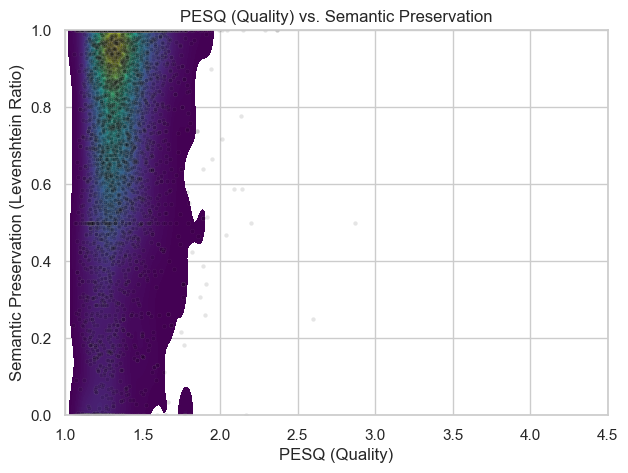

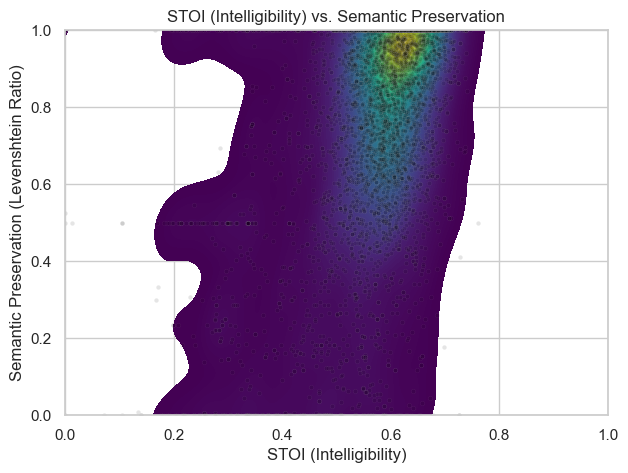

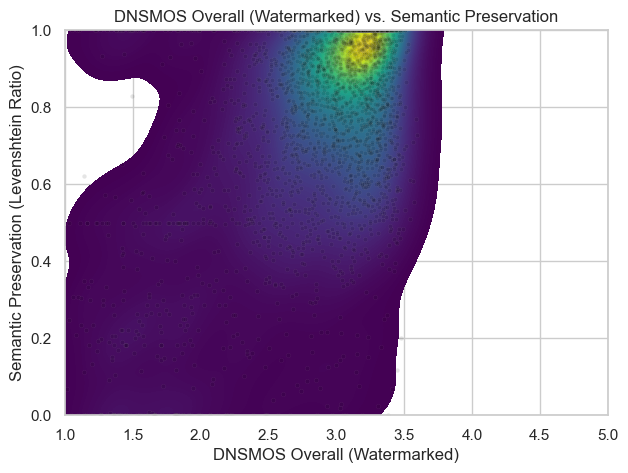

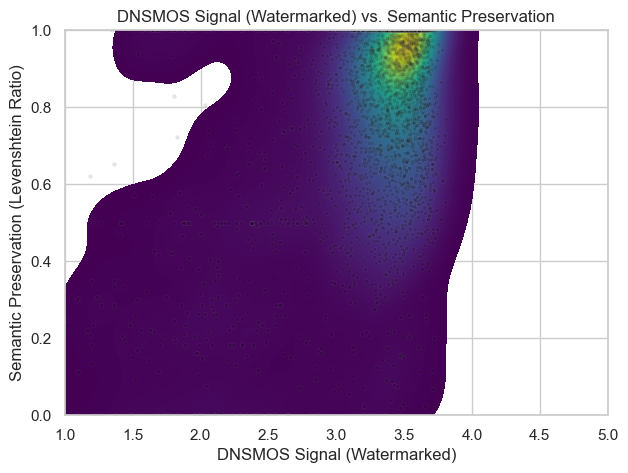

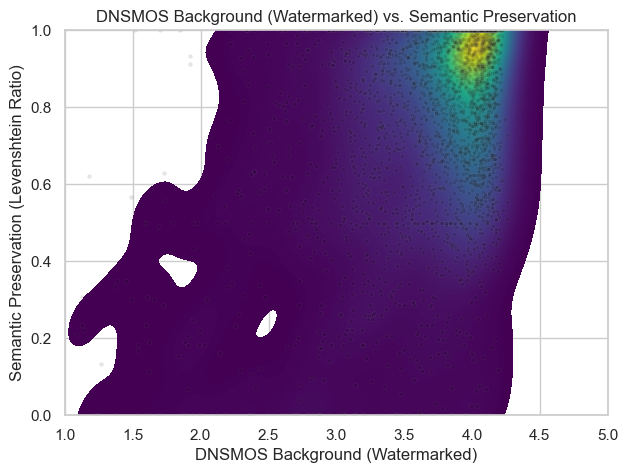

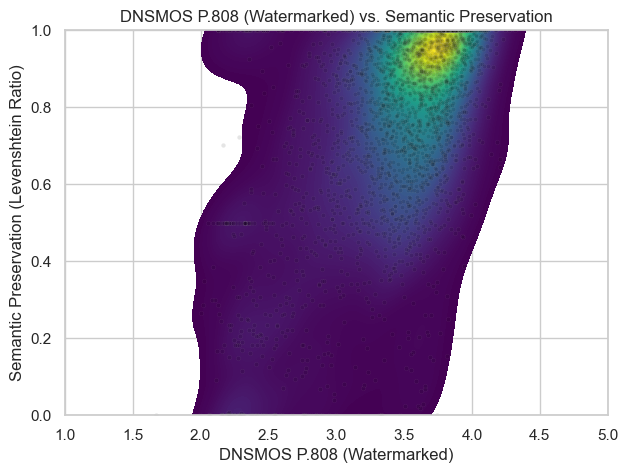

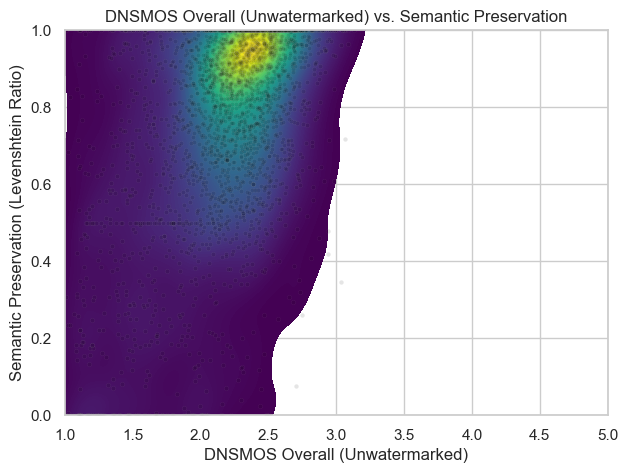

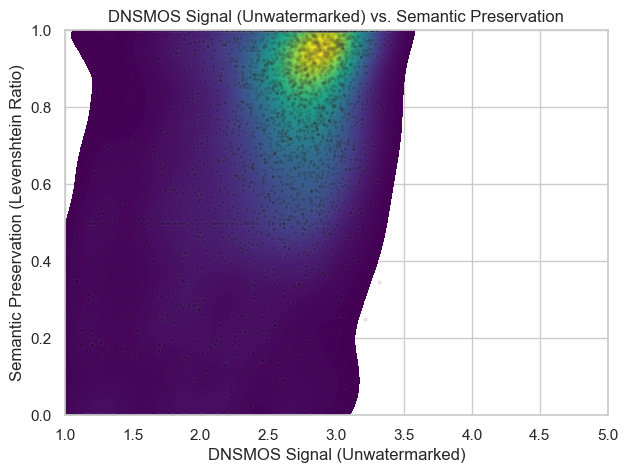

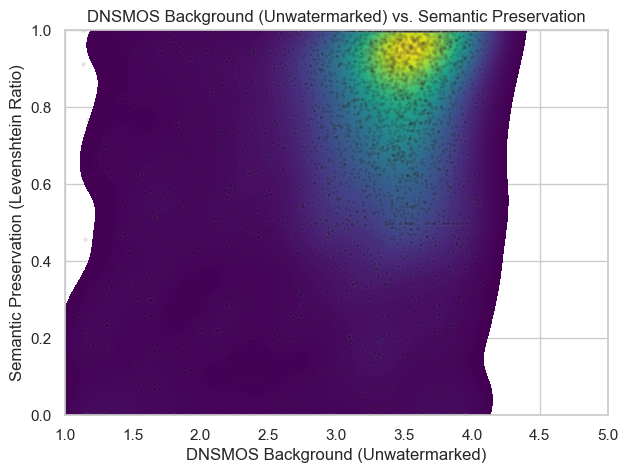

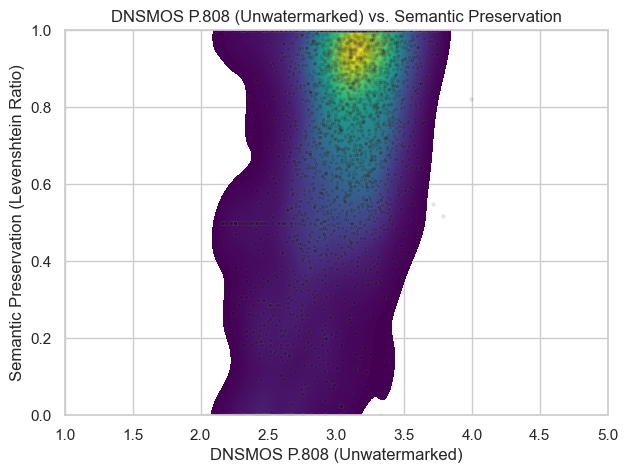

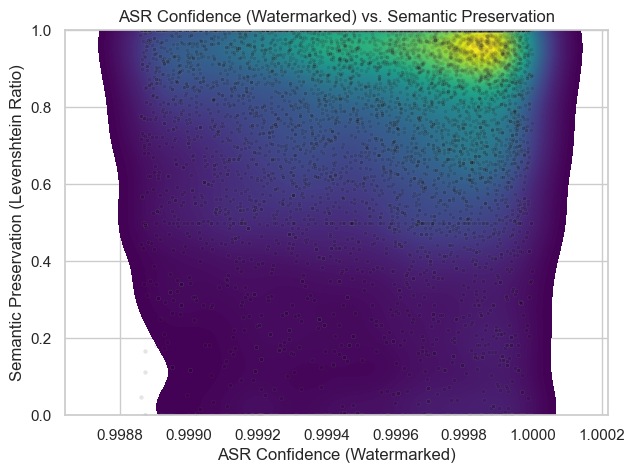

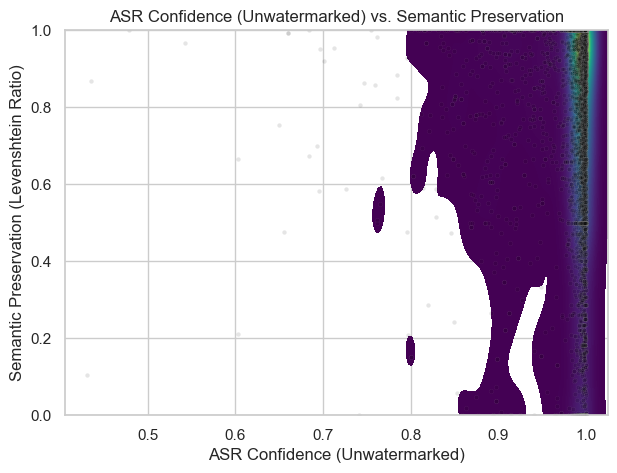

In [96]:
for var in x_vars:
    plt.figure(figsize=(7, 5))

    # Density background
    sns.kdeplot(
        data=audio_quality2,
        x=var,
        y="levenshtein_ratio",
        fill=True,
        cmap="viridis",
        thresh=0.01,
        levels=100
    )

    # Scatter overlay
    sns.scatterplot(
        data=audio_quality2,
        x=var,
        y="levenshtein_ratio",
        color="black",
        alpha=0.1,
        s=10
    )

    # Labels and limits
    plt.xlabel(labels.get(var, var))
    plt.ylabel("Semantic Preservation (Levenshtein Ratio)")
    plt.title(f"{labels.get(var, var)} vs. Semantic Preservation")
    plt.ylim(0, 1)
    if var.startswith("dnsmos"):
        plt.xlim(1, 5)
    elif var == "pesq":
        plt.xlim(1, 4.5)
    elif var == "stoi":
        plt.xlim(0, 1)

    # Save figure
    filename = f"../Paper/Figures/{var}_vs_levenshtein.png"
    plt.savefig(filename, bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

In [91]:
audio_quality2["dnsmos_ovrl_change"] = audio_quality2["dnsmos_ovrl_un"]/audio_quality2["dnsmos_ovrl_w"] - 1

In [99]:
audio_quality2["dnsmos_ovrl_w"].describe()

count    2950.000000
mean        2.859800
std         0.532961
min         0.824300
25%         2.671004
50%         3.019843
75%         3.237702
max         3.594307
Name: dnsmos_ovrl_w, dtype: float64

In [93]:
audio_quality2.columns

Index(['id', 'pesq', 'stoi', 'dnsmos_ovrl_w', 'dnsmos_sig_w', 'dnsmos_bak_w',
       'dnsmos_p808_w', 'dnsmos_ovrl_un', 'dnsmos_sig_un', 'dnsmos_bak_un',
       'dnsmos_p808_un', 'clip', 'transcriptions_w', 'confidence',
       'transcriptions_un', 'unwatermarked_confidence', 'levenshtein_distance',
       'levenshtein_ratio', 'dnsmos_ovrl_change'],
      dtype='object')

count    2950.000000
mean       -0.230937
std         0.118833
min        -0.647403
25%        -0.301273
50%        -0.240325
75%        -0.174010
max         0.514221
Name: dnsmos_ovrl_change, dtype: float64
count    5898.000000
mean        1.348236
std         0.141673
min         1.049344
25%         1.255880
50%         1.327289
75%         1.418171
max         2.871167
Name: pesq, dtype: float64
count    5898.000000
mean        0.576495
std         0.093159
min         0.000010
25%         0.547542
50%         0.595628
75%         0.633306
max         0.760619
Name: stoi, dtype: float64


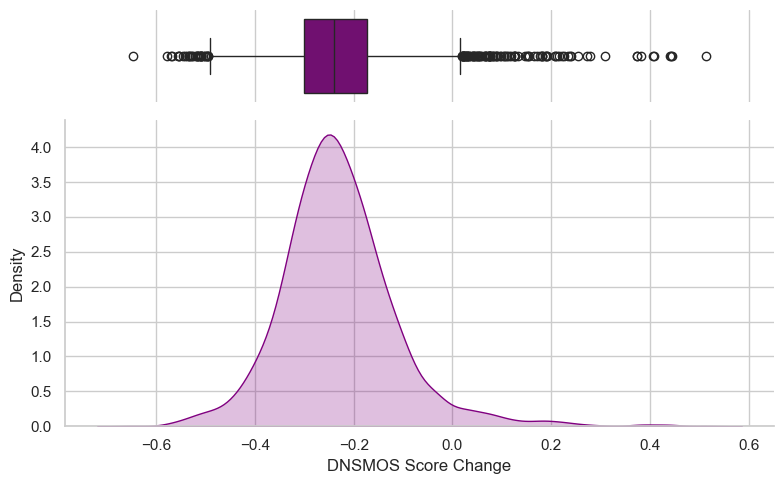

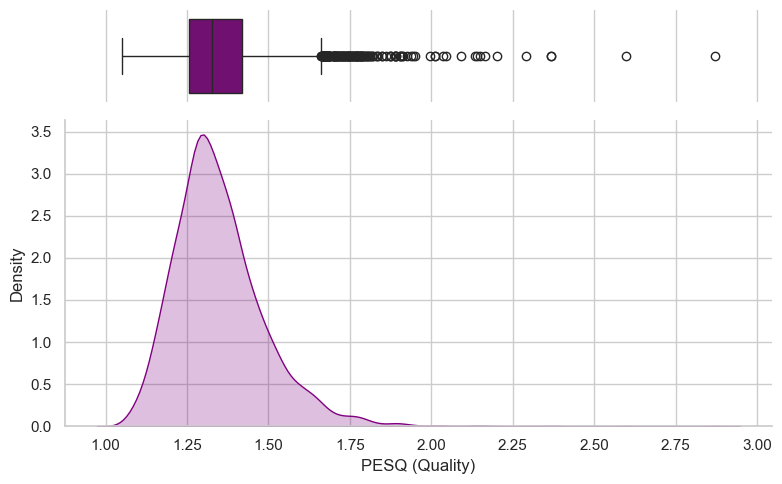

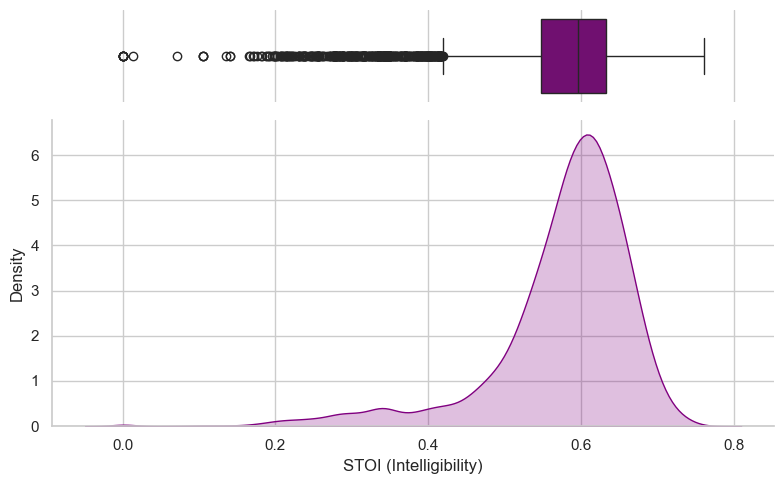

In [98]:
for var in ["dnsmos_ovrl_change", 'pesq', 'stoi']:
    print(audio_quality2[var].describe())
    # Set general style
    sns.set(style="whitegrid")
    fig, (ax_box, ax_kde) = plt.subplots(
        nrows=2, 
        sharex=True, 
        figsize=(8, 5), 
        gridspec_kw={"height_ratios": [0.3, 1]}
    )

    # Remove space between plots
    plt.subplots_adjust(hspace=0)

    # Boxplot on top
    sns.boxplot(
        data=audio_quality2, 
        x=var, 
        ax=ax_box, 
        color="purple", 
        orient="h"
    )
    ax_box.set(xlabel="")
    ax_box.set(yticks=[])
    ax_box.spines["left"].set_visible(False)
    ax_box.spines["right"].set_visible(False)
    ax_box.spines["top"].set_visible(False)
    ax_box.spines["bottom"].set_visible(False)

    # KDE plot below
    sns.kdeplot(
        data=audio_quality2, 
        x=var, 
        fill=True, 
        color="purple", 
        ax=ax_kde
    )
    ax_kde.set_xlabel(labels.get(var, var))

    sns.despine(ax=ax_kde)
    sns.despine(ax=ax_box, left=True, bottom=True)

    plt.tight_layout()
    filename = f"../Paper/Figures/{var}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=300, transparent=True)